In [16]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os, warnings

from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from warnings import simplefilter
simplefilter('ignore')

In [4]:
# Reprductability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

In [6]:
# load training and validation set
ds_train = image_dataset_from_directory(
             '../input/car-or-truck/train',
                labels = 'inferred',
                label_mode = 'binary',
                image_size = [128, 128], 
                interpolation='nearest',
                batch_size = 64,
                shuffle=True)

ds_valid = image_dataset_from_directory(
            '../input/car-or-truck/valid',
                            labels = 'inferred',
                label_mode = 'binary',
                image_size = [128, 128], 
                interpolation='nearest',
                batch_size = 64,
                shuffle=False)

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


In [9]:
ds_train

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [8]:
ds_valid

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [10]:
# Datapipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
            ds_train
            .map(convert_to_float)
            .cache()
            .prefetch(buffer_size=AUTOTUNE))

ds_valid = (
            ds_valid
            .map(convert_to_float)
            .cache()
            .prefetch(buffer_size=AUTOTUNE))


In [12]:
model = tf.keras.Sequential([
        # First Convolutional Block
        tf.keras.layers.Conv2D(kernel_size=3, 
                               filters=32,
                               activation = "relu",
                               padding = 'same',
                               # Giving input dimentions in the first layer
                               # [height, width, color channels[RGB]]
                               input_shape = [128, 128, 3]),
        tf.keras.layers.MaxPool2D(),
        # Second Convolutional Block
        tf.keras.layers.Conv2D(kernel_size=3,
                               filters=64,
                               activation='relu',
                               padding='same'),
        tf.keras.layers.MaxPool2D(),
        # Third Convolutional Block
        tf.keras.layers.Conv2D(kernel_size=3,
                               filters=128,
                               activation='relu',
                               padding='same'),
        tf.keras.layers.MaxPool2D(),
        #classifier Head
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units = 6,
                              activation ='relu'),
        tf.keras.layers.Dense(units=1,
                              activation='sigmoid')
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

In [14]:
# train
model.compile(
        optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
        loss = 'binary_crossentropy',
        metrics=['binary_accuracy'])

In [15]:
# predict
history = model.fit(ds_train,
                    validation_data=ds_valid,
                    epochs=50,
                    verbose=1)

Epoch 1/50
80/80 [==============================] - 92s 1s/step - loss: 0.6777 - binary_accuracy: 0.5738 - val_loss: 0.6689 - val_binary_accuracy: 0.5785
Epoch 2/50
80/80 [==============================] - 88s 1s/step - loss: 0.6608 - binary_accuracy: 0.5787 - val_loss: 0.6566 - val_binary_accuracy: 0.5785
Epoch 3/50
80/80 [==============================] - 86s 1s/step - loss: 0.6543 - binary_accuracy: 0.6129 - val_loss: 0.6488 - val_binary_accuracy: 0.6284
Epoch 4/50
80/80 [==============================] - 87s 1s/step - loss: 0.6474 - binary_accuracy: 0.6224 - val_loss: 0.6401 - val_binary_accuracy: 0.6391
Epoch 5/50
80/80 [==============================] - 87s 1s/step - loss: 0.6402 - binary_accuracy: 0.6297 - val_loss: 0.6326 - val_binary_accuracy: 0.6482
Epoch 6/50
80/80 [==============================] - 88s 1s/step - loss: 0.6319 - binary_accuracy: 0.6387 - val_loss: 0.6259 - val_binary_accuracy: 0.6450
Epoch 7/50
80/80 [==============================] - 89s 1s/step - loss: 0.62

<Axes: >

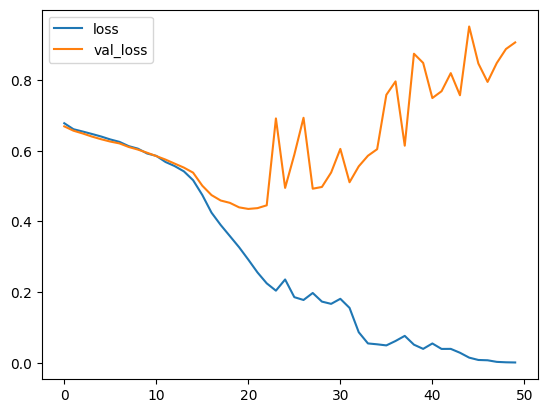

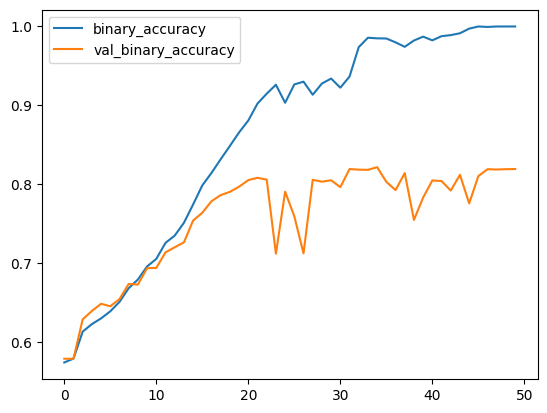

In [18]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:,['loss','val_loss']].plot()
history_frame.loc[:,['binary_accuracy','val_binary_accuracy']].plot()